In [1]:
import os
import torch
device='cuda' if torch.cuda.is_available() else 'cpu' 
from tqdm.notebook import tqdm
from transformers import BertForSequenceClassification, BertTokenizer,BertConfig
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from datasets import load_dataset,load_metric

os.environ["WANDB_DISABLED"] = "true"

In [2]:
train_dataset = load_dataset('glue', 'sst2', split='train',) # challenge, sst2
val_dataset = load_dataset('glue', 'sst2', split='validation')
test_dataset = load_dataset('glue', 'sst2', split='test')

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Reusing dataset glue (/home/as14229/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


Dataset glue downloaded and prepared to /home/as14229/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


Reusing dataset glue (/home/as14229/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [7]:
train_dataset = train_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
val_dataset = val_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
test_dataset = test_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)

val_dataset = val_dataset.remove_columns(['label'])
test_dataset = test_dataset.remove_columns(['label'])
train_dataset = train_dataset.remove_columns(['label'])

Parameter 'function'=<function <lambda> at 0x1456e6824790> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/68 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [4]:
# tokenizer = BertTokenizer.from_pretrained('saved_model')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
MAX_LENGTH = 128
train_dataset = train_dataset.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
val_dataset = val_dataset.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)

Loading cached processed dataset at /home/sp6646/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-e4861ab11925f5b2.arrow
Loading cached processed dataset at /home/sp6646/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-8439974a507d8e1b.arrow
Loading cached processed dataset at /home/sp6646/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-6cbad6fbbb5f7782.arrow


In [6]:
train_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [7]:
train_dataset

Dataset({
    features: ['sentence', 'idx', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 67349
})

In [8]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [9]:
from nn_pruning.sparse_trainer import SparseTrainer

class PruningTrainer(SparseTrainer, Trainer):
    def __init__(self, sparse_args, *args, **kwargs):
        Trainer.__init__(self, *args, **kwargs)
        SparseTrainer.__init__(self, sparse_args)
        
    def compute_loss(self, model, inputs, return_outputs=False):
        """
        We override the default loss in SparseTrainer because it throws an 
        error when run without distillation
        """
        outputs = model(**inputs)

        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
        self.metrics["ce_loss"] += float(loss)
        self.loss_counter += 1
        return (loss, outputs) if return_outputs else loss

In [10]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [11]:
from nn_pruning.patch_coordinator import SparseTrainingArguments

sparse_args = SparseTrainingArguments(
    dense_pruning_method="topK:1d_alt", 
    attention_pruning_method= "topK", 
    initial_threshold= 1.0, 
    final_threshold= 0.5, 
    initial_warmup= 1,
    final_warmup= 3,
    attention_block_rows=32,
    attention_block_cols=32,
    attention_output_with_dense= 0
)
sparse_args

SparseTrainingArguments(mask_scores_learning_rate=0.01, dense_pruning_method='topK:1d_alt', attention_pruning_method='topK', ampere_pruning_method='disabled', attention_output_with_dense=0, bias_mask=True, mask_init='constant', mask_scale=0.0, dense_block_rows=1, dense_block_cols=1, attention_block_rows=32, attention_block_cols=32, initial_threshold=1.0, final_threshold=0.5, initial_warmup=1, final_warmup=3, initial_ampere_temperature=0.0, final_ampere_temperature=20.0, regularization='disabled', regularization_final_lambda=0.0, attention_lambda=1.0, dense_lambda=1.0, distil_teacher_name_or_path=None, distil_alpha_ce=0.5, distil_alpha_teacher=0.5, distil_temperature=2.0, final_finetune=False, layer_norm_patch=False, layer_norm_patch_steps=50000, layer_norm_patch_start_delta=0.99, gelu_patch=False, gelu_patch_steps=50000, linear_min_parameters=0.005, rewind_model_name_or_path=None)

In [12]:
training_args = TrainingArguments(
    output_dir='./results',      
    overwrite_output_dir = 'True',#output directory
    learning_rate=1e-5,
    num_train_epochs=3,
    warmup_steps = 600,
    weight_decay=0.01,
    per_device_train_batch_size=128,                #batch size per device during training
    per_device_eval_batch_size=128,                #batch size for evaluation
    logging_dir='./logs',            
    logging_steps=100,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=False,
    save_total_limit = 1,
    save_strategy = "no",
    seed=42,
    evaluation_strategy="epoch"
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [13]:
import torch 
from nn_pruning.patch_coordinator import ModelPatchingCoordinator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mpc = ModelPatchingCoordinator(
    sparse_args=sparse_args, 
    device=device, 
    cache_dir="checkpoints", 
    logit_names="logits", 
    teacher_constructor=None)

In [14]:
mpc.patch_model(model)
model.save_pretrained("bert_pruned_sst_model/patched")

In [15]:
import numpy as np
from datasets import load_metric

accuracy_score = load_metric('accuracy')

def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)
trainer = PruningTrainer(
    sparse_args=sparse_args,
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [16]:
trainer.set_patch_coordinator(mpc)

In [17]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/scratch/sp6646/envs_dirs/swap_env/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 67349
  Num Epochs = 3
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 1581


Epoch,Training Loss,Validation Loss,Loss,Accuracy,Runtime,Samples Per Second,Steps Per Second,Threshold,Regu Lambda,Ampere Temperature
1,0.247700,0.325871,0.702052,0.509174,2.712700,321.446000,2.580000,0.500000,0.000000,20.000000
2,0.283800,0.264939,0.329949,0.857798,2.574100,338.754000,2.719000,0.500000,0.000000,20.000000
3,0.201700,0.215870,0.294305,0.887615,2.566900,339.710000,2.727000,0.500000,0.000000,20.000000


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 872
  Batch size = 128
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 872
  Batch size = 128
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation **

TrainOutput(global_step=1581, training_loss=0.31061109751557187, metrics={'train_runtime': 1528.9206, 'train_samples_per_second': 132.15, 'train_steps_per_second': 1.034, 'total_flos': 1.3300210312837632e+16, 'train_loss': 0.31061109751557187, 'eval_threshold': 0.5, 'eval_regu_lambda': 0.0, 'eval_ampere_temperature': 20.0, 'epoch': 3.0})

In [18]:
trainer.save_model('./bert_pruned_sst_model')

Saving model checkpoint to ./bert_pruned_sst_model
Configuration saved in ./bert_pruned_sst_model/config.json
Model weights saved in ./bert_pruned_sst_model/pytorch_model.bin
tokenizer config file saved in ./bert_pruned_sst_model/tokenizer_config.json
Special tokens file saved in ./bert_pruned_sst_model/special_tokens_map.json


In [20]:
mpc.compile_model(trainer.model)

(0, 144)

bert.encoder.layer.11.intermediate.dense.weight


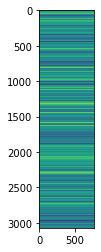

bert.encoder.layer.11.attention.output.dense.weight


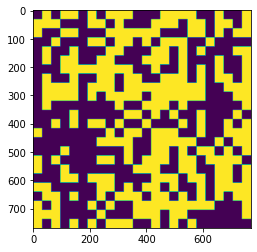

In [21]:
from matplotlib import pyplot as plt

parameters = dict(trainer.model.named_parameters())
param_names = ["bert.encoder.layer.11.intermediate.dense.weight",
               "bert.encoder.layer.11.attention.output.dense.weight"]

for param_name in param_names:          
    w = parameters[param_name]
    print(param_name)

    plt.imshow((w != 0).detach().cpu())
    plt.show()

In [22]:
from nn_pruning.inference_model_patcher import optimize_model

prunebert_model = optimize_model(trainer.model, "dense")

removed heads 0, total_heads=144, percentage removed=0.0
bert.encoder.layer.0.intermediate.dense, sparsity = 50.00
bert.encoder.layer.0.output.dense, sparsity = 50.00
bert.encoder.layer.1.intermediate.dense, sparsity = 50.00
bert.encoder.layer.1.output.dense, sparsity = 50.00
bert.encoder.layer.2.intermediate.dense, sparsity = 50.00
bert.encoder.layer.2.output.dense, sparsity = 50.00
bert.encoder.layer.3.intermediate.dense, sparsity = 50.00
bert.encoder.layer.3.output.dense, sparsity = 50.00
bert.encoder.layer.4.intermediate.dense, sparsity = 50.00
bert.encoder.layer.4.output.dense, sparsity = 50.00
bert.encoder.layer.5.intermediate.dense, sparsity = 50.00
bert.encoder.layer.5.output.dense, sparsity = 50.00
bert.encoder.layer.6.intermediate.dense, sparsity = 50.00
bert.encoder.layer.6.output.dense, sparsity = 50.00
bert.encoder.layer.7.intermediate.dense, sparsity = 50.00
bert.encoder.layer.7.output.dense, sparsity = 50.00
bert.encoder.layer.8.intermediate.dense, sparsity = 50.00
bert.

In [24]:
prunebert_model.num_parameters() / model.num_parameters()

0.7412403506937804

In [27]:
from time import perf_counter

def compute_latencies(model,
                      sentiment="wow such a great movie?",
                      ):
    inputs = tokenizer(sentiment, truncation=True, padding='max_length', max_length=MAX_LENGTH, return_tensors="pt")
    latencies = []
    
    # Warmup
    for _ in range(10):
        _ = model(**inputs)
        
    for _ in range(100):
        start_time = perf_counter()
        _ = model(**inputs)
        latency = perf_counter() - start_time 
        latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies) 
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}") 
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

In [29]:
latencies={}
latencies["prunebert"] = compute_latencies(prunebert_model.to("cpu"))
latencies["bert-base"] = compute_latencies(model.to("cpu"))

Average latency (ms) - 27.69 +\- 0.46
Average latency (ms) - 34.28 +\- 0.75


Text(0.5, 1.0, 'latencies plot')

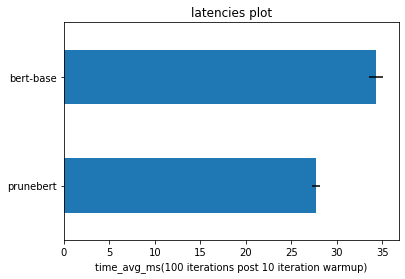

In [34]:
import pandas as pd

df = pd.DataFrame.from_dict(latencies, orient="index")
df.plot(y='time_avg_ms', kind="barh", legend=False, xerr="time_std_ms");
plt.xlabel('time_avg_ms(100 iterations post 10 iteration warmup)')
plt.title('latencies plot')